In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [17]:
pol_to_rep = {
  -1.0: 0,
  -0.9: 1,
  -0.8: 2,
  -0.7: 3,
  -0.6: 4,
  -0.5: 5,
  -0.4: 6,
  -0.3: 7,
  -0.2: 8,
  -0.1: 9,
  -0.0: 10,
  0.0: 10,
  0.1: 11,
  0.2: 12,
  0.3: 13,
  0.4: 14,
  0.5: 15,
  0.6: 16,
  0.7: 17,
  0.8: 18,
  0.9: 19,
  1.0: 20,
}

rep_to_pol = {
  0 : -1.0,
  1 : -0.9,
  2 : -0.8,
  3 : -0.7,
  4 : -0.6,
  5 : -0.5,
  6 : -0.4,
  7 : -0.3,
  8 : -0.2,
  9 : -0.1,
  10 : 0.0,
  11 : 0.1,
  12 : 0.2,
  13 : 0.3,
  14 : 0.4,
  15 : 0.5,
  16 : 0.6,
  17 : 0.7,
  18 : 0.8,
  19 : 0.9,
  20 : 1.0,
}

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_22688/3582254127.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Word_index'].agg(lambda x: list(x))


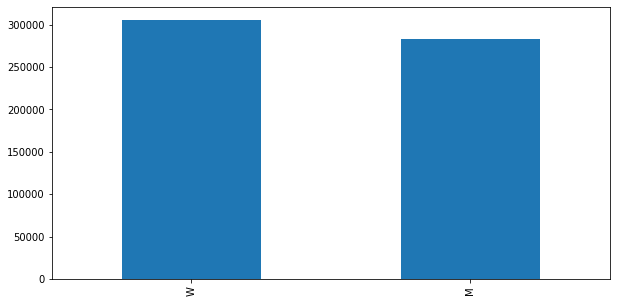

In [18]:
import pandas as pd

df = pd.read_json('C:/Users/Rasmu/Documents/Datasets/7_dataset_w_tags.json')
df = df[:600000]

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['Sentiment'] = df.Gender.apply(lambda x: -1 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df['Dep'] = df['Dep'].str.upper()

df['Polarity_rounded'] = df['Polarity'].apply(lambda s: pol_to_rep[round(float(s), 1)])

word_vocab = np.unique(df['Word']).tolist()
word_vocab.insert(0, '<PAD>')

polarity_range = []

for i in np.arange(0.0, 2.1, 0.1):
    polarity_range.append(int(round(i*10, 1)))

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

df['Word_index'] = df['Word'].map(word_to_i)


df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Word_index'].agg(lambda x: list(x))


In [19]:
tokens = df['Word_index'].tolist()
polarities = df['Polarity_rounded'].tolist()

max_length = max([len(s) for s in tokens])

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding='post')
pad_polarities = pad_sequences(polarities, maxlen=max_length, dtype='int32', padding='post', value=10)

pad_polarities = [to_categorical(i, num_classes=len(pol_to_rep)) for i in pad_polarities]
    
train_tokens, test_tokens, train_polarities, test_polarities = train_test_split(pad_tokens, pad_polarities, test_size=0.25, random_state=42)



In [20]:
# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)

root_logdir = os.path.join(os.curdir, "./logged_models/keras_words")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [21]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import numpy as np
import tensorflow as tf

input_dim = len(word_vocab)+1
embedding_dim = 64
output_dim = 64

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.TimeDistributed(layers.Dense(len(polarity_range), activation="softmax"))
])

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
num_epochs = 20


history = model.fit(train_tokens, np.array(train_polarities), epochs=num_epochs, callbacks =[earlystopping, lr_scheduler, tensorboard_cb], validation_split=0.15)

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 97, 64)            2413312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 97, 64)            33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 97, 21)            1365      
Total params: 2,447,701
Trainable params: 2,447,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1398/1398 [==============================] - 83s 58ms/step - loss: 0.0260 - accuracy: 0.9941 - val_loss: 0.0039 - val_accuracy: 0.9989
Epoch 2/20
1398/1398 [==============================] - 84s 60ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 3/20
1398/1398 [==============================] - 84s 60ms/step - loss: 0.00

In [22]:
y_pred = model.predict(test_tokens)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10] [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


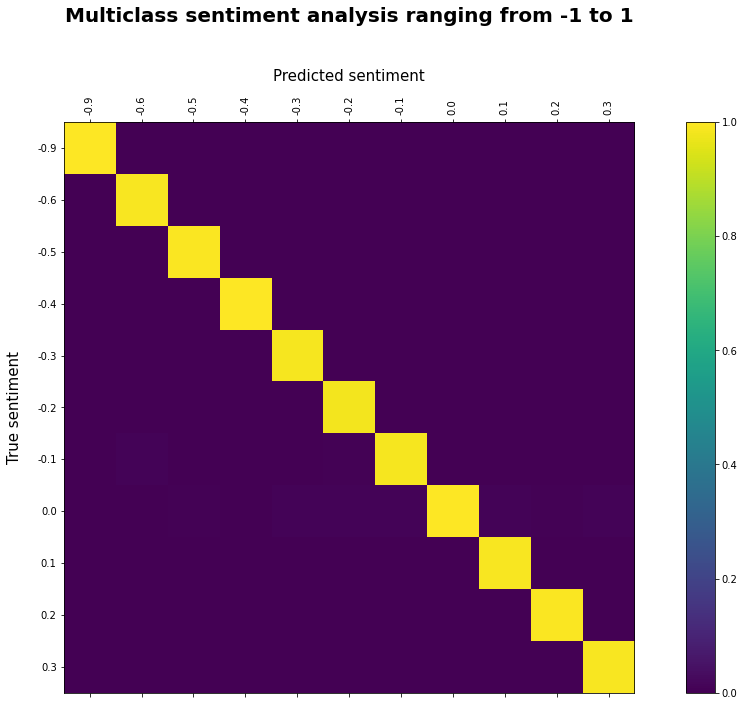

In [27]:
from sklearn.metrics import confusion_matrix
from itertools import chain

y_classes = y_pred.argmax(axis=-1)
cm_true = np.array(test_polarities).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

#cm_true = [x - 10 for x in cm_true]
#cm_pred = [x - 10 for x in cm_pred]


print(cm_true[:30], cm_pred[:30])


cm = confusion_matrix(cm_true, cm_pred, normalize='pred')

print(cm[0])

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted sentiment', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True sentiment', fontsize = 15, labelpad=15.0)
ax.set_title('Multiclass sentiment analysis ranging from -1 to 1',fontweight="bold", size=20, pad=100.0)

conf_x = []

temp = set(chain(*df['Polarity_rounded']))

for i in temp:
    conf_x.append(i)

print(sorted(conf_x))

cm_axis_vals = []

for x in np.unique(np.array(cm_pred)):
    cm_axis_vals.append(rep_to_pol[x])


fig.colorbar(cax)
plt.xticks(range(len(cm[0])),cm_axis_vals, rotation=90)
plt.yticks(range(len(cm[0])), cm_axis_vals)
plt.show()

In [25]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:11]
df_perf_2.insert(loc=0, column='Polarity', value=cm_axis_vals)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Rasmu\AppData\Local\Temp/ipykernel_22688/3914225412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Polarity,precision,recall,f1-score,support
0,-0.9,1.00,1.00,1.00,466.0
1,-0.6,0.99,1.00,0.99,895.0
2,-0.5,0.99,1.00,1.00,2288.0
3,-0.4,1.00,1.00,1.00,2315.0
4,-0.3,0.99,0.99,0.99,5390.0
5,-0.2,0.98,0.99,0.99,18528.0
6,-0.1,0.99,0.99,0.99,44399.0
7,0.0,1.00,1.00,1.00,1621404.0
8,0.1,0.99,0.99,0.99,3326.0
9,0.2,0.99,0.99,0.99,711.0
